**Brian Blaylock**
**November 21, 2018**  Happy Thanksgiving! 🦃

# Cartopy Tutorial

I am told Basemap should no longer be used. That's too bad, becuase it was intuitive and easy to learn and control. Cartopy is missing some things, like US boundaries and US counties built into it. I will, however, figure this out sooner or later.

Resources:
- [Cartopy Documentation](https://scitools.org.uk/cartopy/docs/latest/)
- [Tutorial by Nathan Wendt](https://github.com/nawendt/cartopy-tutorial)
- [MetPy Counties Lines](https://unidata.github.io/MetPy/latest/examples/plots/US_Counties.html#sphx-glr-examples-plots-us-counties-py)

`crs` submodule stands for the Coordinate Reference System and defines the Coordinate Reference Systems and the transformations between them.

> NOTE: you cannot use `pcolormesh` and `cartopy` together with `matplotlib 3.0.0`. Upgrade matplotlib to version `3.0.1` or higher.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import cartopy.crs as ccrs
from cartopy import feature
#from metpy.plots import USCOUNTIES

from pyproj import Proj

In [3]:
# load some HRRR data
gust = np.load('./data/HRRR_F00_20181010-1400_GUST-surface.npy').item()

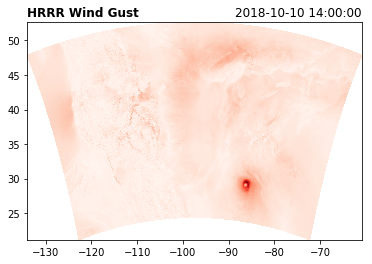

In [4]:
# Plot the raw data on a flat map
plt.pcolormesh(gust['lon'], gust['lat'], gust['value'], cmap='Reds')
plt.title('HRRR Wind Gust', fontweight='semibold', loc='left')
plt.title(gust['valid'], loc='right');

# HRRR Lambert Conformal

From HRRR [namelist.wps](https://rapidrefresh.noaa.gov/hrrr/HRRR/static/HRRRv3/conus/)
>dx = 3000,  
 dy = 3000,  
 map_proj =  'lambert',  
 ref_lat   = 38.5,  
 ref_lon   = -97.5,  
 truelat1  = 38.5,  
 truelat2  = 38.5,  
 stand_lon = -97.5,  

- central_latitude  : 38.5 (same as lat_0 in proj4) 
- central_longitude : -97.5 (same as lon_0)
- standard_parallels: (38.5, 38.5) (same as lat_1, lat_2)

> NOTE: use the **DictName to apply all the dictionary keys to the function arguments

In [5]:
lccProjParams_HRRR = { 'central_latitude'   : -38.5,        # same as lat_0 in proj4 string 
                       'central_longitude'  : -97.5,       # same as lon_0
                       'standard_parallels' : (38.5, 38.5), # same as (lat_1, lat_2)
                     }
proj = ccrs.LambertConformal(**lccProjParams_HRRR)

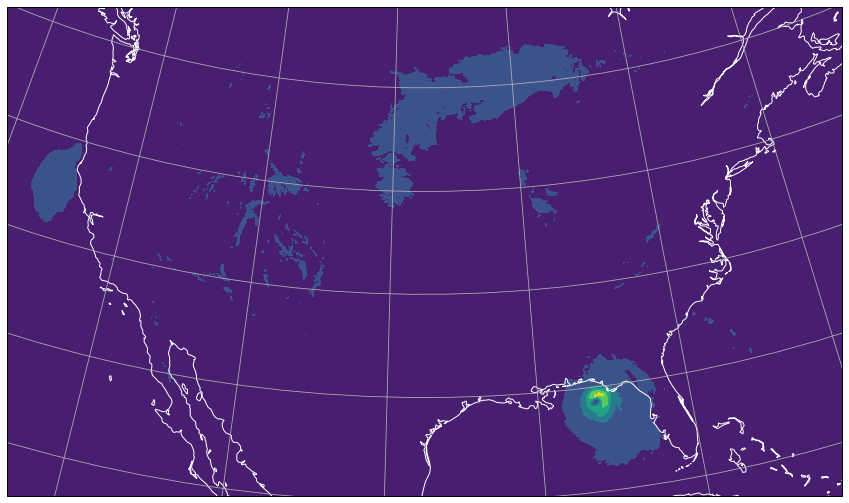

In [34]:
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection = proj)

# "source" projection
# Since we have lat/lon points for every data point, we use PlateCarree
ax.pcolormesh(gust['lon'], gust['lat'], gust['value'], transform=ccrs.PlateCarree())
ax.contourf(gust['lon'], gust['lat'], gust['value'], transform=ccrs.PlateCarree())

ax.coastlines(resolution='50m', color='w')

#ax.set_extent([-130, gust['lon'][-1,-1], gust['lat'].max(), gust['lat'].min()], ccrs.PlateCarree())

## Draw the entire globe (do not auto scale)
#ax.set_global()
ax.gridlines()

In [27]:
gust['lon'][-1,-1]

-60.91719277183784

# GOES 16 Geostationary Projection

In [37]:
import xarray
from pyproj import Proj

In [38]:
C = xarray.open_dataset('./data/OR_ABI-L2-MCMIPC-M3_G16_s20182831437203_e20182831439576_c20182831440087.nc')

In [39]:
# Satellite height
sat_h = C['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals the scanning angle (in radians) multiplied by the satellite height
# See details here: https://proj4.org/operations/projections/geos.html?highlight=geostationary
x = C['x'][:] * sat_h
y = C['y'][:] * sat_h

print('Central Longitude', sat_lon)
print('Satellite_height', sat_h)
print('sweep_axis', sat_sweep)

Central Longitude -75.0
Satellite_height 35786023.0
sweep_axis x


In [40]:
geostationayProjParams_GOES16 = {'central_longitude' : sat_lon,
                                 'satellite_height' : sat_h,
                                 'sweep_axis' : sat_sweep
                                }

GOES16_proj = ccrs.Geostationary(**geostationayProjParams_GOES16)


In [10]:
# Create a pyproj geostationary map object
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

RuntimeError: b'major axis or radius = 0 or not given'

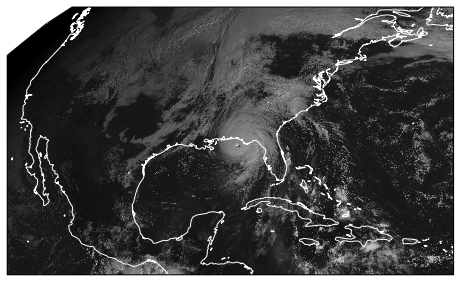

In [10]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection = GOES16_proj)
ax.coastlines('50m', color='w')
ax.imshow(np.flipud(C['CMI_C01']), cmap='Greys_r', extent=(x.min(), x.max(), y.min(), y.max()))

In [ ]:
red = np.load('./data/GOES_ABI_20181010-1438_C02.npy').item()

In [ ]:
plt.figure(figsize=(8,8))
ax = plt.axes(projection=GOES16_proj)
ax.coastlines('50m', color='k')
ax.contourf(red['lon'], red['lat'], red['data'], cmap='Greys_r', transform=ccrs.PlateCarree())

In [ ]:
red

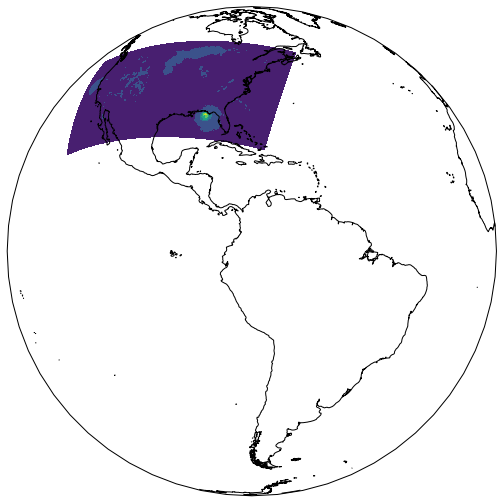

In [19]:
# HRRR on Geostationary Projection
fig = plt.figure(figsize=(16,9))

# "destination" projection
ax = plt.axes(projection = GOES16_proj)

# "source" projection
# Since we have lat/lon points for every data point, we use PlateCarree
#ax.pcolormesh(gust['lon'], gust['lat'], gust['value'], transform=ccrs.PlateCarree())
ax.contourf(gust['lon'], gust['lat'], gust['value'], transform=ccrs.PlateCarree())

ax.coastlines(resolution='50m')

ax.set_global()

In [35]:
# GOES CONUS data on HRRR projection

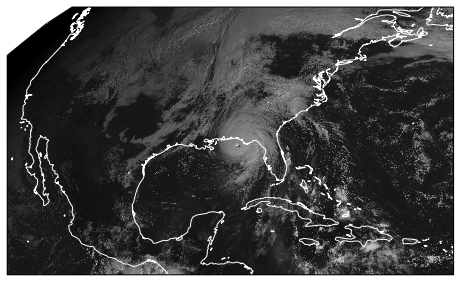

In [41]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection = GOES16_proj)
ax.coastlines('50m', color='w')
ax.imshow(np.flipud(C['CMI_C01']), cmap='Greys_r', extent=(x.min(), x.max(), y.min(), y.max()))

In [45]:
red = np.load('./data/GOES_ABI_20181010-1438_C02.npy').item()
latlon = np.load('./data/GOES_ABI_2km_latlon.npy').item()

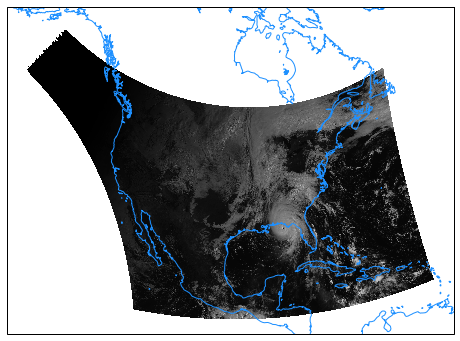

In [51]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection = proj)
ax.coastlines('50m', color='dodgerblue')
ax.pcolormesh(latlon['lon'], latlon['lat'], red['data'], cmap='Greys_r', transform=ccrs.PlateCarree())

In [ ]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection = proj)
ax.coastlines('50m', color='dodgerblue')
ax.pcolormesh(latlon['lon'], latlon['lat'], red['data'], cmap='Greys_r', transform=ccrs.PlateCarree())

In [69]:
XX, YY = np.meshgrid(x, y)

In [78]:
a = proj.transform_points(ccrs.PlateCarree(), XX, YY)

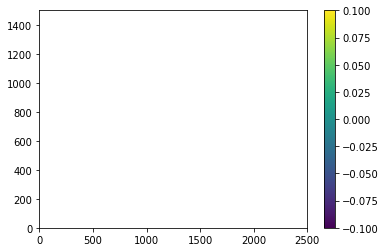

In [79]:
plt.pcolormesh(a[:,:,1])
plt.colorbar()

7500000

In [ ]:
plt.figure(figsize=(8, 8))
ax = plt.axes(projection=ccrs.Miller())
extent = [-5500000, 5500000, -5500000, 5500000]
ax.imshow(red['data'], transform=GOES16_proj, extent=extent, origin='upper', cmap='gray')

ax.coastlines('50m', color='dodgerblue')